# Importing Libraries:

In [58]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import plotly.express as px
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from tqdm import tqdm
from gensim.models import Word2Vec
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer 
import re
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import MinMaxScaler
from scipy.sparse import hstack
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import RandomizedSearchCV

In [59]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [60]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [61]:
# Reading data and dropping some features:
path = '/content/drive/MyDrive/dataset/train_donor.csv'
data = pd.read_csv(path)
new = data.drop(['teacher_id','Unnamed: 0','project_essay_3','project_essay_4','project_submitted_datetime'],axis = 1)
#new = new.sample(n = 3000)

In [62]:
path2 = '/content/drive/MyDrive/dataset/resources.csv'
resource = pd.read_csv(path2)

In [63]:
# Dimensions of the given data:

print(new.shape)
new.head(2)

(109248, 12)


,id,teacher_prefix,school_state,project_grade_category,project_subject_categories,project_subject_subcategories,project_title,project_essay_1,project_essay_2,project_resource_summary,teacher_number_of_previously_posted_projects,project_is_approved
0,p253737,Mrs.,IN,Grades PreK-2,Literacy & Language,"ESL, Literacy",Educational Support for English Learners at Home,My students are English learners that are work...,"\""The limits of your language are the limits o...",My students need opportunities to practice beg...,0,0
1,p258326,Mr.,FL,Grades 6-8,"History & Civics, Health & Sports","Civics & Government, Team Sports",Wanted: Projector for Hungry Learners,Our students arrive to our school eager to lea...,The projector we need for our school is very c...,My students need a projector to help with view...,7,1


In [64]:
resource.head(2)

,id,description,quantity,price
0,p233245,LC652 - Lakeshore Double-Space Mobile Drying Rack,1,149.00
1,p069063,Bouncy Bands for Desks (Blue support pipes),3,14.95


In [65]:
# Grouping by (project id) and summing up the (price) & (quantity) for a given (id):
# Because for a given project there could be multiple resources hence, we are adding the prices & quantity required for each project

resource_data = resource.groupby('id').agg({'price':'sum', 'quantity':'sum'}).reset_index()
resource_data.head(4)

,id,price,quantity
0,p000001,459.56,7
1,p000002,515.89,21
2,p000003,298.97,4
3,p000004,1113.69,98


In [66]:
# Merging the two dataframes:

new_data = new.merge(resource_data,on = 'id', how = 'left')
print(new_data.shape)
new_data.head(4)

(109248, 14)


,id,teacher_prefix,school_state,project_grade_category,project_subject_categories,project_subject_subcategories,project_title,project_essay_1,project_essay_2,project_resource_summary,teacher_number_of_previously_posted_projects,project_is_approved,price,quantity
0,p253737,Mrs.,IN,Grades PreK-2,Literacy & Language,"ESL, Literacy",Educational Support for English Learners at Home,My students are English learners that are work...,"\""The limits of your language are the limits o...",My students need opportunities to practice beg...,0,0,154.60,23
1,p258326,Mr.,FL,Grades 6-8,"History & Civics, Health & Sports","Civics & Government, Team Sports",Wanted: Projector for Hungry Learners,Our students arrive to our school eager to lea...,The projector we need for our school is very c...,My students need a projector to help with view...,7,1,299.00,1
2,p182444,Ms.,AZ,Grades 6-8,Health & Sports,"Health & Wellness, Team Sports",Soccer Equipment for AWESOME Middle School Stu...,"\r\n\""True champions aren't always the ones th...",The students on the campus come to school know...,"My students need shine guards, athletic socks,...",1,0,516.85,22
3,p246581,Mrs.,KY,Grades PreK-2,"Literacy & Language, Math & Science","Literacy, Mathematics",Techie Kindergarteners,I work at a unique school filled with both ESL...,My students live in high poverty conditions wi...,My students need to engage in Reading and Math...,4,1,232.90,4


# Data Visualization:

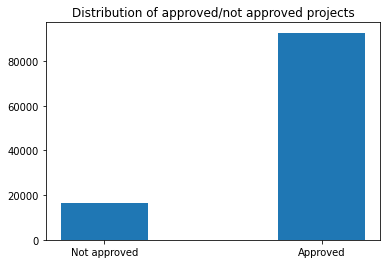

Percentage of approved projects:85%
Percentage of NOT approved projects:15%


In [67]:
# Distribution of Approved and Not Approved Projects:

counts = new['project_is_approved'].value_counts()
x_axis = ['Not approved', 'Approved']
y_axis = [counts[0],counts[1]]
plt.bar(x_axis,y_axis,width = 0.4)
plt.title('Distribution of approved/not approved projects')
plt.show()

print('Percentage of approved projects:{}%'.format(round((counts[1]*100)/len(new)),2))
print('Percentage of NOT approved projects:{}%'.format(round((counts[0]*100)/len(new)),2))

-- We see that this is the case of an imbalanced datset.

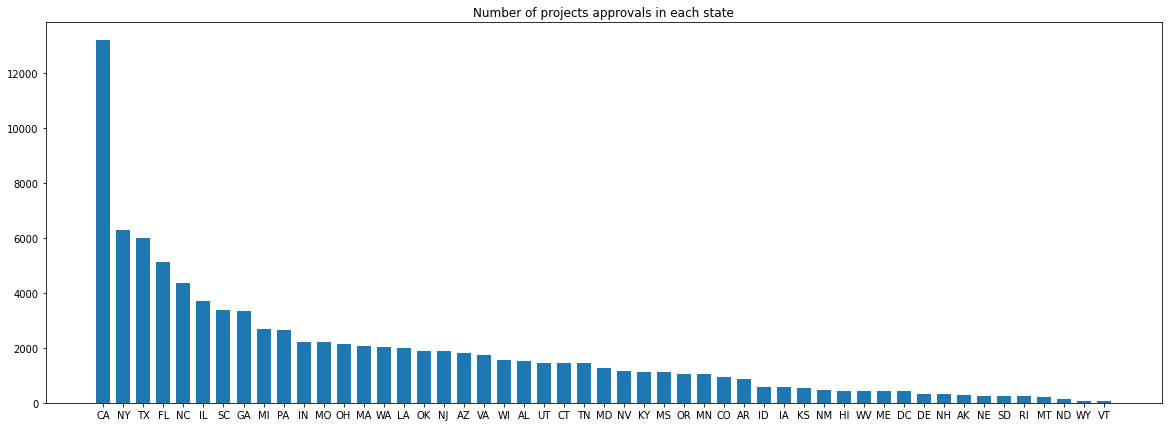

***************************************************************************
The top 3 states with highest approval are:
   school_state  project_is_approved
4            CA                13205
34           NY                 6291
43           TX                 6014
***************************************************************************
The 3 states with lowest approval:
   school_state  project_is_approved
28           ND                  127
50           WY                   82
46           VT                   64


In [68]:
# Bar plot for number of project approval's in each state:

state_app = new_data.groupby('school_state').agg({'project_is_approved': 'sum'}).reset_index()  # group by
state_app.sort_values(by=['project_is_approved'],inplace=True, ascending=False) # sorting in descending order

plt.figure(figsize=(20, 7))
x_state = list(state_app['school_state'].values) # defining x axis
y_state = list(state_app['project_is_approved'].values) # defining y axis
plt.bar(x_state,y_state,width = 0.7)
plt.title('Number of projects approvals in each state')
plt.show()
print('*'*75)
print('The top 3 states with highest approval are:')
print(state_app.head(3))
print('*'*75)
print('The 3 states with lowest approval:')
print(state_app.tail(3))

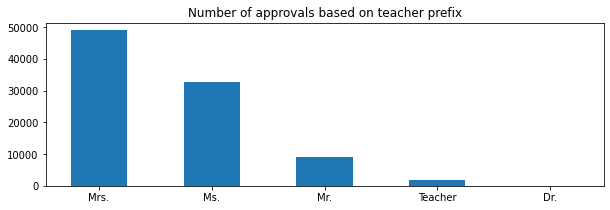

***************************************************************************
The top 2 prefixes with highest approval are:
  teacher_prefix  project_is_approved
2           Mrs.                48997
3            Ms.                32860
***************************************************************************
The 2 prefixes with lowest approval:
  teacher_prefix  project_is_approved
4        Teacher                 1877
0            Dr.                    9


In [69]:
# Frequency of approvals for teacher prefixes:

teacher_app = new_data.groupby('teacher_prefix').agg({'project_is_approved': 'sum'}).reset_index()
teacher_app.sort_values(by=['project_is_approved'],inplace=True, ascending=False)

plt.figure(figsize=(10, 3))
x_teacher = list(teacher_app['teacher_prefix'].values)
y_teacher = list(teacher_app['project_is_approved'].values)
plt.bar(x_teacher,y_teacher,width = 0.5)
plt.title('Number of approvals based on teacher prefix')
plt.show()
print('*'*75)
print('The top 2 prefixes with highest approval are:')
print(teacher_app.head(2))
print('*'*75)
print('The 2 prefixes with lowest approval:')
print(teacher_app.tail(2))

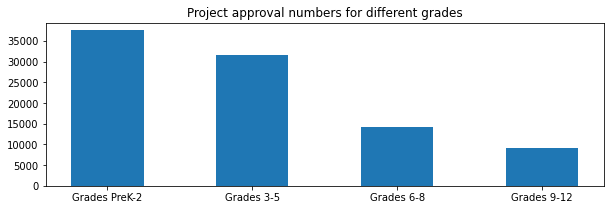

***************************************************************************
The top 2 Grade Category with highest approval are:
  project_grade_category  project_is_approved
3          Grades PreK-2                37536
0             Grades 3-5                31729
***************************************************************************
The 2 Grade Category with lowest approval:
  project_grade_category  project_is_approved
1             Grades 6-8                14258
2            Grades 9-12                 9183


In [70]:
# Frequency of approvals based on project_grade_categorys:

grade_app = new_data.groupby('project_grade_category').agg({'project_is_approved': 'sum'}).reset_index()
grade_app.sort_values(by=['project_is_approved'],inplace=True, ascending=False)

plt.figure(figsize=(10, 3))
x_grade = list(grade_app['project_grade_category'].values)
y_grade = list(grade_app['project_is_approved'].values)
plt.bar(x_grade,y_grade,width = 0.5)
plt.title('Project approval numbers for different grades')
plt.show()
print('*'*75)
print('The top 2 Grade Category with highest approval are:')
print(grade_app.head(2))
print('*'*75)
print('The 2 Grade Category with lowest approval:')
print(grade_app.tail(2))

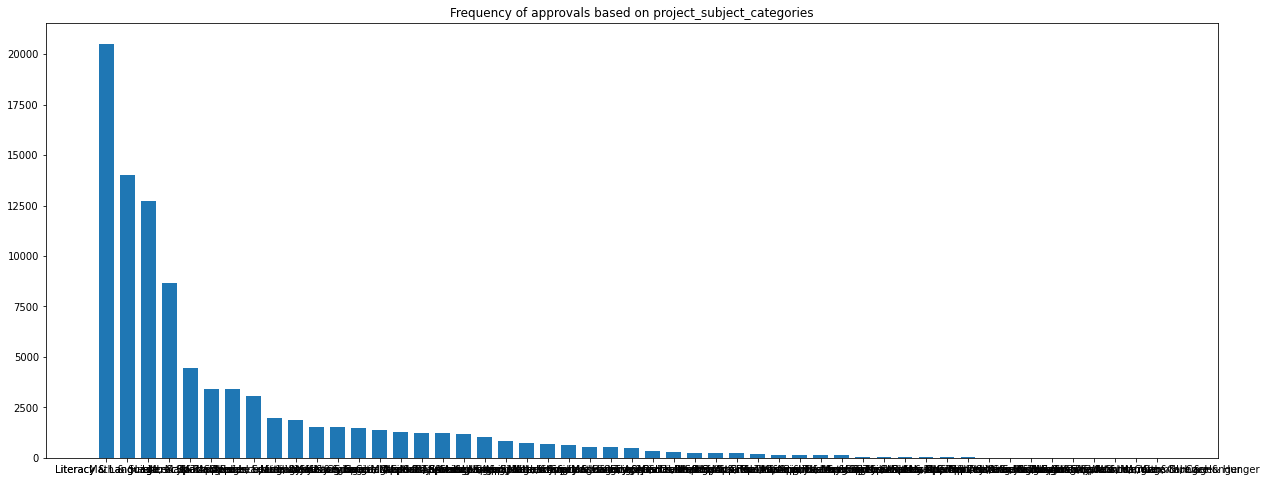

***************************************************************************
The top 3 Subject Category with highest approval are:
             project_subject_categories  project_is_approved
24                  Literacy & Language                20520
32                       Math & Science                13991
28  Literacy & Language, Math & Science                12725
***************************************************************************
The 3 Subject Category with lowest approval:
                 project_subject_categories  project_is_approved
39    Math & Science, Warmth, Care & Hunger                    6
45  Music & The Arts, Warmth, Care & Hunger                    1
23  History & Civics, Warmth, Care & Hunger                    0


In [71]:
# Frequency of approvals based on project_subject_categories:

subject_app = new_data.groupby('project_subject_categories').agg({'project_is_approved': 'sum'}).reset_index()
subject_app.sort_values(by=['project_is_approved'],inplace=True, ascending=False)

plt.figure(figsize=(21, 8))
x_subject = list(subject_app['project_subject_categories'].values)
y_subject = list(subject_app['project_is_approved'].values)
plt.bar(x_subject,y_subject,width = 0.7)
plt.title('Frequency of approvals based on project_subject_categories')
plt.show()
print('*'*75)
print('The top 3 Subject Category with highest approval are:')
print(subject_app.head(3))
print('*'*75)
print('The 3 Subject Category with lowest approval:')
print(subject_app.tail(3))

In [111]:
# Checking outliers for number of projects previously submitted by teacher:

q1 = np.percentile(new_data['teacher_number_of_previously_posted_projects'].values,25)
q2 = np.percentile(new_data['teacher_number_of_previously_posted_projects'].values,50)
q3 = np.percentile(new_data['teacher_number_of_previously_posted_projects'].values,75)
q90 = np.percentile(new_data['teacher_number_of_previously_posted_projects'].values,90)
q95 = np.percentile(new_data['teacher_number_of_previously_posted_projects'].values,95)
q4 = np.percentile(new_data['teacher_number_of_previously_posted_projects'].values,99)
q5 = np.percentile(new_data['teacher_number_of_previously_posted_projects'].values,100)

print('25th percentile:',q1)
print('50th percentile:',q2)
print('75th percentile:',q3)
print('90th percentile:',q90)
print('95th percentile:',q95)
print('99th percentile:',q4)
print('100th percentile:',q5)

25th percentile: 0.0
50th percentile: 2.0
75th percentile: 9.0
90th percentile: 28.0
95th percentile: 53.0
99th percentile: 139.0
100th percentile: 451.0


- Here, 99% of the values lie within 53 i.e 99% of the teachers have submitted less than or equal to 139 projetcs
- We will be dropping the rows having value greater than (139).

In [112]:
# Checking outliers for quantiy required for completion of project:

q1 = np.percentile(new_data['quantity'].values,25)
q2 = np.percentile(new_data['quantity'].values,50)
q3 = np.percentile(new_data['quantity'].values,75)
q90 = np.percentile(new_data['quantity'].values,90)
q95 = np.percentile(new_data['quantity'].values,95)
q99 = np.percentile(new_data['quantity'].values,99)
q4 = np.percentile(new_data['quantity'].values,100)

print('25th percentile:',q1)
print('50th percentile:',q2)
print('75th percentile:',q3)
print('90th percentile:',q90)
print('95th percentile:',q95)
print('99th percentile:',q99)
print('100th percentile:',q4)

25th percentile: 4.0
50th percentile: 9.0
75th percentile: 21.0
90th percentile: 39.0
95th percentile: 58.0
99th percentile: 120.0
100th percentile: 930.0


- Here we will be dropping all values greater than (120).

In [113]:
# Checking outliers for price of resources:

q1 = np.percentile(new_data['price'].values,25)
q2 = np.percentile(new_data['price'].values,50)
q3 = np.percentile(new_data['price'].values,75)
q90 = np.percentile(new_data['price'].values,90)
q95 = np.percentile(new_data['price'].values,95)
q99 = np.percentile(new_data['price'].values,99)
q4 = np.percentile(new_data['price'].values,100)

print('25th percentile:',q1)
print('50th percentile:',q2)
print('75th percentile:',q3)
print('90th percentile:',q90)
print('95th percentile:',q95)
print('99th percentile:',q99)
print('100th percentile:',q4)

25th percentile: 104.31
50th percentile: 206.22
75th percentile: 379.0
90th percentile: 619.4530000000001
95th percentile: 839.9865
99th percentile: 1583.449999999999
100th percentile: 9999.0


In [115]:
# We want to see the 99th percentile values closely.
for i in range(10,110,10):
    print(99+(i/100),'percentile :',np.percentile(new_data['price'].values,99+(i/100)))


99.1 percentile : 1626.1420200000005
99.2 percentile : 1690.994320000001
99.3 percentile : 1763.4215399999885
99.4 percentile : 1827.8057800000188
99.5 percentile : 1915.99
99.6 percentile : 1999.99
99.7 percentile : 2269.7053900000506
99.8 percentile : 2895.3575599999926
99.9 percentile : 3999.0
100.0 percentile : 9999.0


- As we can see, only 1% of the data has price greater than (1584). So, we will be considering this value as the threshold to drop the rows.

In [75]:
# Extracting 2 features: (Length of title & number of stopwords in the title)

nltk.download('stopwords')
stop_words = set(stopwords.words("english"))

def len_words(texts):
    '''
    This function returns the length of the sentence
    
    '''
    sentence = texts.lower().strip()
    sentence = sentence.split()
    final = len(sentence)
    return final

def remove_stopwords(texts):
    '''
    This function returns the number of stopwords in a sentence
    
    '''
    sentence = texts.lower().strip()
    sentence = sentence.split()
    final = [word for word in sentence if word in set(stop_words)]
    final1 = len(final)
    
    return final1

n1= new_data['project_title'].values

sent_len = [] # this contains length of the sentences.
for z in range(len(n1)):
    res = len_words(str(n1[z]))
    sent_len.append(res)

stopword_len = [] # this contains number of stopwords from a sentence.
for z in range(len(n1)):
    res2 = remove_stopwords(str(n1[z]))
    stopword_len.append(res2)  

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [76]:
# Adding the 2 new features to the dataframe.

new_data['len_title'] = sent_len
new_data['len_stopword'] = stopword_len
new_data.head(2)

,id,teacher_prefix,school_state,project_grade_category,project_subject_categories,project_subject_subcategories,project_title,project_essay_1,project_essay_2,project_resource_summary,teacher_number_of_previously_posted_projects,project_is_approved,price,quantity,len_title,len_stopword
0,p253737,Mrs.,IN,Grades PreK-2,Literacy & Language,"ESL, Literacy",Educational Support for English Learners at Home,My students are English learners that are work...,"\""The limits of your language are the limits o...",My students need opportunities to practice beg...,0,0,154.6,23,7,2
1,p258326,Mr.,FL,Grades 6-8,"History & Civics, Health & Sports","Civics & Government, Team Sports",Wanted: Projector for Hungry Learners,Our students arrive to our school eager to lea...,The projector we need for our school is very c...,My students need a projector to help with view...,7,1,299.0,1,5,1


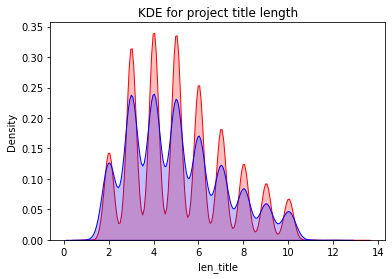

In [77]:
# KDE plot for the project title length.

sns.kdeplot(new_data[new_data['project_is_approved'] == 1.0]['len_title'][0:] , label = "1", color = 'red',shade = True)
sns.kdeplot(new_data[new_data['project_is_approved'] == 0.0]['len_title'][0:] , label = "0" , color = 'blue',shade = True)
plt.title('KDE for project title length')
plt.show()

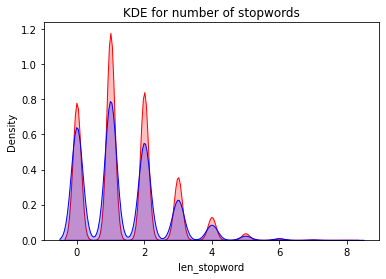

In [78]:
# KDE plot for number of stopwords in project title.

sns.kdeplot(new_data[new_data['project_is_approved'] == 1.0]['len_stopword'][0:] , label = "1", color = 'red',shade = True)
sns.kdeplot(new_data[new_data['project_is_approved'] == 0.0]['len_stopword'][0:] , label = "0" , color = 'blue',shade = True)
plt.title('KDE for number of stopwords')
plt.show()

-- As there is major overlapping in both cases, the above two extracted features do not help much in our classification task and hence will be dropped further.

# Data Cleaning:

# Teacher_prefix

In [79]:
# Checking null values and if any, filling it with the most occuring category:

null_teacher = new_data['teacher_prefix'].isnull().values.any() # checking null values, if any
if null_teacher == True:
    new_data['teacher_prefix']=new_data['teacher_prefix'].fillna('Mrs.') # filling up the nan values

# Cleaning of the prefixes:
teacher_prefix = []
for i in list(new_data['teacher_prefix'].values):
    txt = i.lower() # converting to lowercase
    txt = re.sub(" ",'', txt) # getting rid of empty spaces
    txt = re.sub(r'\W','',txt) # getting rid of whatever is a non-word character
    teacher_prefix.append(txt)

print(list(new_data['teacher_prefix'].values)[:5])    
print('*'*50)
print(teacher_prefix[:5])

['Mrs.', 'Mr.', 'Ms.', 'Mrs.', 'Mrs.']
**************************************************
['mrs', 'mr', 'ms', 'mrs', 'mrs']


# School state:

In [80]:
null_state = new_data['school_state'].isnull().values.any()
if null_state == True:
    new_data['school_state']=new_data['school_state'].fillna('CA')

school_state = []
for i in list(new_data['school_state'].values):
    txt = i.lower()
    txt = re.sub(" ",'', txt)
    txt = re.sub(r'\W','',txt)
    school_state.append(txt)

print(list(new_data['school_state'].values)[:5])    
print('*'*50)    
print(school_state[:5])

['IN', 'FL', 'AZ', 'KY', 'TX']
**************************************************
['in', 'fl', 'az', 'ky', 'tx']


# Project Grade Category:

In [81]:
null_grade = new_data['project_grade_category'].isnull().values.any()
if null_grade == True:
    new_data['project_grade_category']=new_data['project_grade_category'].fillna('Grades PreK-2')

project_grade_category = []
for i in list(new_data['project_grade_category'].values):
    txt = i.lower()
    txt = re.sub(" ",'_', txt)
    txt = re.sub(r'\W','_',txt)
    project_grade_category.append(txt)

print(list(new_data['project_grade_category'].values)[:5])    
print('*'*50)    
print(project_grade_category[:5])

['Grades PreK-2', 'Grades 6-8', 'Grades 6-8', 'Grades PreK-2', 'Grades PreK-2']
**************************************************
['grades_prek_2', 'grades_6_8', 'grades_6_8', 'grades_prek_2', 'grades_prek_2']


# Project Subject Categories:

In [82]:
null_subject = new_data['project_subject_categories'].isnull().values.any()
if null_subject == True:
    new_data['project_subject_categories']=new_data['project_subject_categories'].fillna('Literacy & Language')

project_subject_category = []
for i in list(new_data['project_subject_categories'].values):
    txt = re.sub(' ','', i)
    txt = txt.replace('The','')
    txt = txt.replace('&','_')
    txt = txt.replace(',','_')
    txt = txt.lower()
    project_subject_category.append(txt)

print(list(new_data['project_subject_categories'].values)[:5])    
print('*'*100)    
print(project_subject_category[:5])

['Literacy & Language', 'History & Civics, Health & Sports', 'Health & Sports', 'Literacy & Language, Math & Science', 'Math & Science']
****************************************************************************************************
['literacy_language', 'history_civics_health_sports', 'health_sports', 'literacy_language_math_science', 'math_science']


# Project Subject Subcategories:

In [83]:
null_subsubject = new_data['project_subject_subcategories'].isnull().values.any()
if null_subsubject == True:
    new_data['project_subject_subcategories']=new_data['project_subject_subcategories'].fillna('Literacy')

project_subject_subcategory = []
for i in list(new_data['project_subject_subcategories'].values):
    txt = re.sub(' ','', i)
    txt = txt.replace('The','')
    txt = txt.replace('&','_')
    txt = txt.replace(',','_')
    txt = txt.lower()
    project_subject_subcategory.append(txt)

print(list(new_data['project_subject_subcategories'].values)[:5])    
print('*'*100)    
print(project_subject_subcategory[:5])

['ESL, Literacy', 'Civics & Government, Team Sports', 'Health & Wellness, Team Sports', 'Literacy, Mathematics', 'Mathematics']
****************************************************************************************************
['esl_literacy', 'civics_government_teamsports', 'health_wellness_teamsports', 'literacy_mathematics', 'mathematics']


# Project Title:

In [84]:
from nltk.stem.snowball import SnowballStemmer
stop_words = set(stopwords.words("english"))
snow_stemmer = SnowballStemmer(language='english')

stop_words.remove('not')
stop_words.remove('between')
stop_words.remove('up')
stop_words.remove('down')
stop_words.remove('in')
stop_words.remove('out')
stop_words.remove('before')
stop_words.remove('after')
stop_words.remove('few')
stop_words.remove('more')
stop_words.remove('most')
stop_words.remove('no')
stop_words.remove('nor')

def clean(text):
    '''
    This function gets rid of all punctuation marks, special characters, stop words
    and expands the contracted words and returns words after applying stemming
    
    '''
    sent = text.lower().strip() 
    sent = re.sub('[^a-zA-Z]',' ',text) 
    sent = sent.replace("won't", "will not").replace("cannot", "can not").replace("can't", "can not")\
                        .replace("n't", " not").replace("what's", "what is").replace("it's", "it is")\
                           .replace("'ve", " have").replace("i'm", "i am").replace("'re", " are")\
                           .replace("he's", "he is").replace("she's", "she is").replace("'s", " own")\
                           .replace("%", " percent ").replace("₹", " rupee ").replace("$", " dollar ")\
                           .replace("€", " euro ").replace("'ll", " will").replace("doesn't", "does not")
                           
    sent = sent.split()
    final = [snow_stemmer.stem(word) for word in sent if not word in set(stop_words)]
    final_sent =  ' '.join(final)
    return final_sent

project_title = [] 
for z in range(len(n1)):
    r1 = clean(str(n1[z]))
    project_title.append(r1)

print(list(n1[:2]))
print('*'*100)
print(project_title[:2])

['Educational Support for English Learners at Home', 'Wanted: Projector for Hungry Learners']
****************************************************************************************************
['educ support english learner home', 'want projector hungri learner']


# Project Essay 1:

In [85]:
n2 = new_data['project_essay_1'].values

project_essay_1 = [] 
for z in tqdm(range(len(n2))):
    r2 = clean(str(n2[z]))
    project_essay_1.append(r2)

100%|██████████| 109248/109248 [02:14<00:00, 811.32it/s]


# Project Essay 2:

In [86]:
n3 = new_data['project_essay_2'].values

project_essay_2 = [] 
for z in tqdm(range(len(n3))):
    r3 = clean(str(n3[z]))
    project_essay_2.append(r3)

100%|██████████| 109248/109248 [03:17<00:00, 554.45it/s]


# Project Resource Summary:

In [87]:
n4 = new_data['project_resource_summary'].values

project_resource_summary = [] 
for z in tqdm(range(len(n4))):
    r4 = clean(str(n4[z]))
    project_resource_summary.append(r4)

100%|██████████| 109248/109248 [00:26<00:00, 4077.50it/s]


In [88]:
# Adding the cleaned texts and features to the dataframe:

data_ = new_data.drop(['teacher_prefix','school_state','project_grade_category','project_subject_categories','project_subject_subcategories','project_title','project_essay_1','project_essay_2','project_resource_summary'],axis = 1)
data_['teacher_prefix'] = teacher_prefix
data_['school_state'] = school_state
data_['project_grade_category'] = project_grade_category
data_['project_subject_category'] = project_subject_category
data_['project_subject_subcategory'] = project_subject_subcategory
data_['project_title'] = project_title
data_['project_essay_1'] = project_essay_1
data_['project_essay_2'] = project_essay_2
data_['project_resource_summary'] = project_resource_summary


In [116]:
# Eliminating the outliers for 'number of projects posted by teachers':

data_.drop(data_[data_['teacher_number_of_previously_posted_projects'] > 139].index, inplace = True)

In [118]:
# Eliminating the outliers for 'quantity':


data_.drop(data_[data_['quantity'] > 120].index, inplace = True)

In [123]:
# Eliminating the outliers for 'price': (greater than 1584 are dropped)

data_.drop(data_[data_['price'] > 1584].index, inplace = True)


In [127]:
print('{} outliers have been removed from the dataset'.format(new_data.shape[0] - data_.shape[0]))

3220 outliers have been removed from the dataset


In [124]:
print(data_.shape)
data_.head(2)

(106028, 16)


,id,teacher_number_of_previously_posted_projects,project_is_approved,price,quantity,len_title,len_stopword,teacher_prefix,school_state,project_grade_category,project_subject_category,project_subject_subcategory,project_title,project_essay_1,project_essay_2,project_resource_summary
0,p253737,0,0,154.6,23,7,2,mrs,in,grades_prek_2,literacy_language,esl_literacy,educ support english learner home,my student english learner work english second...,the limit languag limit world ludwig wittgenst...,my student need opportun practic begin read sk...
1,p258326,7,1,299.0,1,5,1,mr,fl,grades_6_8,history_civics_health_sports,civics_government_teamsports,want projector hungri learner,our student arriv school eager learn they poli...,the projector need school crucial academ impro...,my student need projector help view educ program


# Data Preprocessing:

In [128]:
x = data_.drop(['project_is_approved','id'], axis = 1) # independent varirables
y = data_['project_is_approved'] # dependent variable

In [129]:
print(x.shape)
x.head(3)

(106028, 14)


,teacher_number_of_previously_posted_projects,price,quantity,len_title,len_stopword,teacher_prefix,school_state,project_grade_category,project_subject_category,project_subject_subcategory,project_title,project_essay_1,project_essay_2,project_resource_summary
0,0,154.60,23,7,2,mrs,in,grades_prek_2,literacy_language,esl_literacy,educ support english learner home,my student english learner work english second...,the limit languag limit world ludwig wittgenst...,my student need opportun practic begin read sk...
1,7,299.00,1,5,1,mr,fl,grades_6_8,history_civics_health_sports,civics_government_teamsports,want projector hungri learner,our student arriv school eager learn they poli...,the projector need school crucial academ impro...,my student need projector help view educ program
2,1,516.85,22,7,1,ms,az,grades_6_8,health_sports,health_wellness_teamsports,soccer equip awesom middl school student,r n true champion alway one win most gut by mi...,the student campus come school know face uphil...,my student need shine guard athlet sock soccer...


# Splitting the Dataset:

In [130]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size = 0.3,stratify = y,random_state = 0)

x_trnew,x_cv,y_trnew,y_cv = train_test_split(x_train,y_train,test_size = 0.3,stratify = y_train,random_state = 0)

print('Original train data shape',x_train.shape)
print('='*100)
print('Original test data shape',x_test.shape)
print('='*100)
print('New train shape',x_trnew.shape)
print('='*100)
print('CV shape',x_cv.shape)
print('='*100)

Original train data shape (74219, 14)
Original test data shape (31809, 14)
New train shape (51953, 14)
CV shape (22266, 14)


# TF-IDF vectorization on 'Project_Title' 

In [131]:
tfidf1 = TfidfVectorizer(min_df=10,ngram_range=(1,3), max_features=1000)

tfidf_title_train_orignal = tfidf1.fit_transform(x_train['project_title'].values)
tfidf_title_test_orignal = tfidf1.transform(x_test['project_title'].values)
tfidf_title_train_new = tfidf1.transform(x_trnew['project_title'].values)
tfidf_title_cv = tfidf1.transform(x_cv['project_title'].values)

print('After TF-IDF')
print('Original train data shape',tfidf_title_train_orignal.shape)
print('='*100)
print('Original test data shape',tfidf_title_test_orignal.shape)

After TF-IDF
Original train data shape (74219, 1000)
Original test data shape (31809, 1000)


# TF-IDF vectorization on 'Essay 1'

In [132]:
tfidf = TfidfVectorizer(min_df=10,ngram_range=(1,4), max_features=1000)

tfidf_essay1_train_orignal = tfidf.fit_transform(x_train['project_essay_1'].values)
tfidf_essay1_test_orignal = tfidf.transform(x_test['project_essay_1'].values)
tfidf_essay1_train_new = tfidf.transform(x_trnew['project_essay_1'].values)
tfidf_essay1_cv = tfidf.transform(x_cv['project_essay_1'].values)

print('After TF-IDF')
print('Original train data shape',tfidf_essay1_train_orignal.shape)
print('='*100)
print('Original test data shape',tfidf_essay1_test_orignal.shape)

After TF-IDF
Original train data shape (74219, 1000)
Original test data shape (31809, 1000)


# TF-IDF vectorization on 'Essay 2' 

In [133]:
tfidf2 = TfidfVectorizer(min_df=10,ngram_range=(1,4), max_features=1000)

tfidf_essay2_train_orignal = tfidf2.fit_transform(x_train['project_essay_2'].values)
tfidf_essay2_test_orignal = tfidf2.transform(x_test['project_essay_2'].values)
tfidf_essay2_train_new = tfidf2.transform(x_trnew['project_essay_2'].values)
tfidf_essay2_cv = tfidf2.transform(x_cv['project_essay_2'].values)

print('After TF-IDF')
print('Original train data shape',tfidf_essay2_train_orignal.shape)
print('='*100)
print('Original test data shape',tfidf_essay2_test_orignal.shape)

After TF-IDF
Original train data shape (74219, 1000)
Original test data shape (31809, 1000)


# TF-IDF vectorization on 'Resource summary' 

In [134]:
tfidf3 = TfidfVectorizer(min_df=10,ngram_range=(1,4), max_features=1000)

tfidf_summary_train_orignal = tfidf3.fit_transform(x_train['project_resource_summary'].values)
tfidf_summary_test_orignal = tfidf3.transform(x_test['project_resource_summary'].values)
tfidf_summary_train_new = tfidf3.transform(x_trnew['project_resource_summary'].values)
tfidf_summary_cv = tfidf3.transform(x_cv['project_resource_summary'].values)

print('After TF-IDF')
print('Original train data shape',tfidf_summary_train_orignal.shape)
print('='*100)
print('Original test data shape',tfidf_summary_test_orignal.shape)

After TF-IDF
Original train data shape (74219, 1000)
Original test data shape (31809, 1000)


# One hot encoding for TEACHER_PREFIX:

In [135]:
ONE = OneHotEncoder(sparse = False, handle_unknown = 'ignore')

teacher_pre_ohe_train_orig = ONE.fit_transform(x_train['teacher_prefix'].values.reshape(-1,1))
teacher_pre_ohe_test_orig = ONE.transform(x_test['teacher_prefix'].values.reshape(-1,1))
teacher_pre_ohe_train_new = ONE.transform(x_trnew['teacher_prefix'].values.reshape(-1,1))
teacher_pre_ohe_cv = ONE.transform(x_cv['teacher_prefix'].values.reshape(-1,1))

print('Original train data shape',teacher_pre_ohe_train_orig.shape)
print('='*100)
print('Original test data shape',teacher_pre_ohe_test_orig.shape)
print('='*100)
print(teacher_pre_ohe_train_orig[0])

Original train data shape (74219, 5)
Original test data shape (31809, 5)
[0. 0. 1. 0. 0.]


# OHE on project_grade_category

In [136]:
ONEa = OneHotEncoder(sparse = False, handle_unknown = 'ignore')

pg_ohe_train_orig = ONEa.fit_transform(x_train['project_grade_category'].values.reshape(-1,1))
pg_ohe_test_orig = ONEa.transform(x_test['project_grade_category'].values.reshape(-1,1))
pg_ohe_train_new = ONEa.transform(x_trnew['project_grade_category'].values.reshape(-1,1))
pg_ohe_cv = ONEa.transform(x_cv['project_grade_category'].values.reshape(-1,1))

print('Original train data shape',pg_ohe_train_orig.shape)
print('='*100)
print('Original test data shape',pg_ohe_test_orig.shape)
print('='*100)
print(pg_ohe_train_orig[0])

Original train data shape (74219, 4)
Original test data shape (31809, 4)
[1. 0. 0. 0.]


# OHE on school state

In [137]:
ONEb = OneHotEncoder(sparse = False, handle_unknown = 'ignore')

ss_train_orig = ONEb.fit_transform(x_train['school_state'].values.reshape(-1,1))
ss_test_orig = ONEb.transform(x_test['school_state'].values.reshape(-1,1))
ss_train_new = ONEb.transform(x_trnew['school_state'].values.reshape(-1,1))
ss_cv = ONEb.transform(x_cv['school_state'].values.reshape(-1,1))

print('Original train data shape',ss_train_orig.shape)
print('='*100)
print('Original test data shape',ss_test_orig.shape)
print('='*100)
print(ss_train_orig[0])

Original train data shape (74219, 51)
Original test data shape (31809, 51)
[0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0.]


# OHE on subject_categories

In [138]:
ONEc = OneHotEncoder(sparse = False, handle_unknown = 'ignore')

cc_train_orig = ONEc.fit_transform(x_train['project_subject_category'].values.reshape(-1,1))
cc_test_orig = ONEc.transform(x_test['project_subject_category'].values.reshape(-1,1))
cc_train_new = ONEc.transform(x_trnew['project_subject_category'].values.reshape(-1,1))
cc_cv = ONEc.transform(x_cv['project_subject_category'].values.reshape(-1,1))

print('Original train data shape',cc_train_orig.shape)
print('='*100)
print('Original test data shape',cc_test_orig.shape)

Original train data shape (74219, 51)
Original test data shape (31809, 51)


# OHE on subject_subcategories

In [139]:
ONEd = OneHotEncoder(sparse = False, handle_unknown = 'ignore')

csc_train_orig = ONEd.fit_transform(x_train['project_subject_subcategory'].values.reshape(-1,1))
csc_test_orig = ONEd.transform(x_test['project_subject_subcategory'].values.reshape(-1,1))
csc_train_new = ONEd.transform(x_trnew['project_subject_subcategory'].values.reshape(-1,1))
csc_cv = ONEd.transform(x_cv['project_subject_subcategory'].values.reshape(-1,1))

print('Original train data shape',csc_train_orig.shape)
print('='*100)
print('Original test data shape',csc_test_orig.shape)

Original train data shape (74219, 392)
Original test data shape (31809, 392)


# Normalization of number of previously posted projects

In [140]:
scaled = MinMaxScaler()
scaled.fit(x_train['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))

numprojects_train_orig = scaled.transform(x_train['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))
numprojects_test_orig = scaled.transform(x_test['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))
numprojects_train_new = scaled.transform(x_trnew['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))
numprojects_cv = scaled.transform(x_cv['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))

print('Original train data shape',numprojects_train_orig.shape)
print('='*100)
print('Original test data shape for number of projects',numprojects_test_orig.shape)
print('='*100)
print(numprojects_train_orig[:5])

Original train data shape (74219, 1)
Original test data shape for number of projects (31809, 1)
[[0.00719424]
 [0.05755396]
 [0.00719424]
 [0.00719424]
 [0.20143885]]


# Normalization of price:

In [141]:
scaled.fit(x_train['price'].values.reshape(-1,1))

price_train_orig = scaled.transform(x_train['price'].values.reshape(-1,1))
price_test_orig = scaled.transform(x_test['price'].values.reshape(-1,1))
price_train_new = scaled.transform(x_trnew['price'].values.reshape(-1,1))
price_cv = scaled.transform(x_cv['price'].values.reshape(-1,1))

print('Original train data shape',price_train_orig.shape)
print('='*100)
print('Original test data shape for number of projects',price_test_orig.shape)
print('='*100)
print(price_train_orig[:5])

Original train data shape (74219, 1)
Original test data shape for number of projects (31809, 1)
[[0.1343887 ]
 [0.04658185]
 [0.22360425]
 [0.20627661]
 [0.0460449 ]]


# Normalization of quantity:

In [142]:
scaled.fit(x_train['quantity'].values.reshape(-1,1))

quantity_train_orig = scaled.transform(x_train['quantity'].values.reshape(-1,1))
quantity_test_orig = scaled.transform(x_test['quantity'].values.reshape(-1,1))
quantity_train_new = scaled.transform(x_trnew['quantity'].values.reshape(-1,1))
quantity_cv = scaled.transform(x_cv['quantity'].values.reshape(-1,1))

print('Original train data shape',quantity_train_orig.shape)
print('='*100)
print('Original test data shape for number of projects',quantity_test_orig.shape)
print('='*100)
print(quantity_train_orig[:5])

Original train data shape (74219, 1)
Original test data shape for number of projects (31809, 1)
[[0.05882353]
 [0.03361345]
 [0.10084034]
 [0.07563025]
 [0.10084034]]


# Concatenating:

In [143]:
X_train = hstack((tfidf_title_train_orignal,tfidf_essay1_train_orignal,tfidf_essay2_train_orignal,tfidf_summary_train_orignal,teacher_pre_ohe_train_orig,pg_ohe_train_orig,ss_train_orig,cc_train_orig,csc_train_orig,numprojects_train_orig,price_train_orig,quantity_train_orig)).tocsr()
X_test = hstack((tfidf_title_test_orignal,tfidf_essay1_test_orignal,tfidf_essay2_test_orignal,tfidf_summary_test_orignal,teacher_pre_ohe_test_orig,pg_ohe_test_orig,ss_test_orig,cc_test_orig,csc_test_orig,numprojects_test_orig,price_test_orig,quantity_test_orig)).tocsr()
X_trn = hstack((tfidf_title_train_new,tfidf_essay1_train_new,tfidf_essay2_train_new,tfidf_summary_train_new,teacher_pre_ohe_train_new,pg_ohe_train_new,ss_train_new,cc_train_new,csc_train_new,numprojects_train_new,price_train_new,quantity_train_new)).tocsr()
X_cv = hstack((tfidf_title_cv,tfidf_essay1_cv,tfidf_essay2_cv,tfidf_summary_cv,teacher_pre_ohe_cv,pg_ohe_cv,ss_cv,cc_cv,csc_cv,numprojects_cv,price_cv,quantity_cv)).tocsr()

print("Final Data matrix")
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)
print(X_trn.shape, y_trnew.shape)
print(X_cv.shape, y_cv.shape)
print("="*100)

Final Data matrix
(74219, 4506) (74219,)
(31809, 4506) (31809,)
(51953, 4506) (51953,)
(22266, 4506) (22266,)


# ML Model:

# Applying Naive Bayes with hyperparameter tuning:

100%|██████████| 11/11 [00:02<00:00,  5.05it/s]


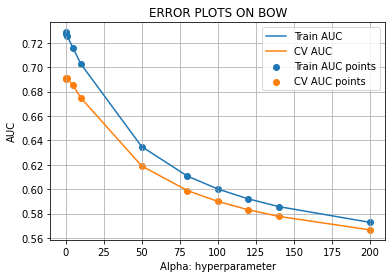

In [144]:
new_train_auc = [] # this stores the training scores
cv_auc = [] # this stores the CV scores

alpha = [0.1,0.5,1,5,10,50,80,100,120,140,200] # trying different values of alpha to find the best one
for i in tqdm(alpha):
    naive = MultinomialNB(alpha=i,class_prior = [0.5, 0.5])
    naive.fit(X_trn, y_trnew)

    y_newtrain_pred =  naive.predict_proba(X_trn)[:,1] # getting probability values for approved projects from train data
    y_cv_pred = naive.predict_proba(X_cv)[:,1] # getting probability values for approved projects from CV data
     
    new_train_auc.append(roc_auc_score(y_trnew,y_newtrain_pred)) # appending the auc scores for train data
    cv_auc.append(roc_auc_score(y_cv,y_cv_pred)) # appending the auc scores for CV data

# Plotting the AUC values to check the best alpha which gives good AUC score with much less overfitting
plt.plot(alpha, new_train_auc, label='Train AUC')
plt.plot(alpha, cv_auc, label='CV AUC')

plt.scatter(alpha, new_train_auc, label='Train AUC points')
plt.scatter(alpha, cv_auc, label='CV AUC points')

plt.legend()
plt.xlabel("Alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS ON BOW")
plt.grid()
plt.show()

# Fitting model to best value of alpha: (11)

In [145]:
best_alpha = 11
naive = MultinomialNB(alpha=best_alpha,class_prior = [0.5, 0.5])
naive.fit(X_train, y_train)

naive_train_pred =  naive.predict_proba(X_train)[:,1]
naive_test_pred = naive.predict_proba(X_test)[:,1]

naive_train_score = roc_auc_score(y_train,naive_train_pred)
naive_test_score = roc_auc_score(y_test,naive_test_pred)

print(naive_train_score)
print(naive_test_score)

0.7012320454546372
0.6814699114301265


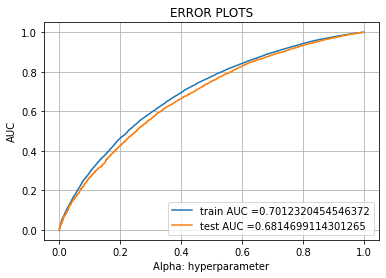

In [146]:
train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, naive_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, naive_test_pred)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("Alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.grid()
plt.show()

# Applying Random Forest with Randomdized Search CV:

In [147]:
'''
# Defining some parameters:
trees = [5,8,10,15,20,25,30,50]
depth = [2,4,6,8,10]
min_sample = [2,5,7]

parameters = {'n_estimators':trees,'max_depth':depth,'min_samples_split':min_sample}

rf = RandomForestClassifier()
random_search = RandomizedSearchCV(estimator = rf, param_distributions = parameters, cv = 10)
random_search.fit(X_train, y_train)

random_search.best_params_

'''

"\n# Defining some parameters:\ntrees = [5,8,10,15,20,25,30,50]\ndepth = [2,4,6,8,10]\nmin_sample = [2,5,7]\n\nparameters = {'n_estimators':trees,'max_depth':depth,'min_samples_split':min_sample}\n\nrf = RandomForestClassifier()\nrandom_search = RandomizedSearchCV(estimator = rf, param_distributions = parameters, cv = 10)\nrandom_search.fit(X_train, y_train)\n\nrandom_search.best_params_\n\n"

-- Adjusting the best hyperparameters obtained to--->(n_estimators= 40, min_samples_split= 7, max_depth=5,max_samples = 0.5) for avoiding overfitting to the training data.

# Random Forest on Best Hyperparameters:

In [148]:
rf_best = RandomForestClassifier(n_estimators= 40, min_samples_split= 7, max_depth=5,max_samples = 0.5, criterion = 'entropy', random_state = 0)
rf_best.fit(X_train,y_train)
sig_clf = CalibratedClassifierCV(rf_best, method="sigmoid")
sig_clf.fit(X_train, y_train)

rf_train_predict = sig_clf.predict_proba(X_train)[:,1]
rf_test_predict = sig_clf.predict_proba(X_test)[:,1]

rf_train_score = roc_auc_score(y_train,rf_train_predict)
rf_test_score = roc_auc_score(y_test,rf_test_predict)

print(rf_train_score)
print(rf_test_score)

0.7395949092508893
0.7015863097148183


- Train AUC score = 0.74, Test AUC score = 0.701


# XGBoost

In [149]:
import xgboost as xgb

'''
#params = {'learning_rate': [0.03,0.05,0.10,0.15],
          #'max_depth': [3,4,5,6,8],
          #'min_child_weight': [1,3,5,7],
          #'gamma': [0.1,0.2,0.3,0.4],
          #'colsample_bytree': [0.3,0.4,0.5,0.7]
         # }
#classifier = xgb.XGBClassifier()
#random_cv = RandomizedSearchCV(classifier,param_distributions = params, n_iter = 5,scoring = 'roc_auc',cv = 5, verbose = 3)
#random_cv.fit(X_train,y_train)

#random_cv.best_params_

'''

"\n#params = {'learning_rate': [0.03,0.05,0.10,0.15],\n          #'max_depth': [3,4,5,6,8],\n          #'min_child_weight': [1,3,5,7],\n          #'gamma': [0.1,0.2,0.3,0.4],\n          #'colsample_bytree': [0.3,0.4,0.5,0.7]\n         # }\n#classifier = xgb.XGBClassifier()\n#random_cv = RandomizedSearchCV(classifier,param_distributions = params, n_iter = 5,scoring = 'roc_auc',cv = 5, verbose = 3)\n#random_cv.fit(X_train,y_train)\n\n#random_cv.best_params_\n\n"

In [150]:
classifier = xgb.XGBClassifier(colsample_bytree = 0.3,gamma= 0.8,learning_rate= 0.06,max_depth= 4,min_child_weight=8)
classifier.fit(X_train,y_train)
xgboost_pred_train = classifier.predict_proba(X_train)[:,1]
xgboost_pred_test = classifier.predict_proba(X_test)[:,1]

xgb_train_uc = roc_auc_score(y_train,xgboost_pred_train)
xgb_test_auc = roc_auc_score(y_test,xgboost_pred_test)

print(xgb_train_uc)
print(xgb_test_auc)


0.7710956915091236
0.7308144733268176


- Train AUC Score = 0.77, Test AUC Score = 0.73